In [42]:
import numpy as np
import time
from matplotlib import pyplot as plt
import re
class FiniteV(object):
    def __init__(self, filepath, T_inf=226.5, Ma_inf=6, 
                 Re_inf=10000, rho_inf=1, r=1, R0=287, gamma=1.4):
        self.k = 0.026 # 取空气的导热系数为0.026
        self.T_inf = T_inf
        self.Ma_inf = Ma_inf
        self.Re_inf = Re_inf
        self.rho_inf = rho_inf
        self.r = r
        self.R0 = R0
        self.gamma = gamma
        self._parameter_init()
        self._read_net(filepath)
        self._node_data_init() # 设置虚拟网格点
        self._get_cell_center() # 网格中心坐标
        self._cen_part_xi_ita() # 中心坐标处xi_x, xi_y
        self._get_edge_partxy() # 边界坐标导数
        self.fig = plt.figure(dpi=300)
        self.ax = self.fig.add_axes([0.1, 0.1, 0.8, 0.8])
        self.ax.set_aspect(1)
        self.ax.xaxis.set_visible(False)
        self.ax.yaxis.set_visible(False)
        self.img = self.ax.pcolormesh(self.x_cen[1:-1, 1:-1], self.y_cen[1:-1, 1:-1], self.node_data[0, 1:-1, 1:-1])
        return
    
    def _parameter_init(self):
        self.T_wall = self.T_inf * 4.2
        c_inf = np.sqrt(self.gamma * self.R0 * self.T_inf)
        self.u_inf = self.Ma_inf * c_inf
        self.mu_inf =  self.rho_inf * self.r * self.u_inf / self.Re_inf
        self.v_inf = 0
        return

    def _read_net(self, filepath):
        with open(filepath) as file:
            for i,line in enumerate(file):
                if i == 0:
                    print("Reading the data!")
                if i == 1:
                    str_line = re.split('\s+', line)
                    self.m, self.n = int(str_line[3]), int(str_line[5])
                    self.x = np.zeros(shape=(self.m, self.n))
                    self.y = np.zeros(shape=(self.m, self.n))
                if i > 1:
                    loc_0, loc_1 = divmod(i - 2, self.m) # 获取存储位置
                    _, str1, str2, _ = re.split('\s+', line)
                    self.x[self.m - loc_1 - 1, self.n - loc_0 - 1] = float(str1)
                    self.y[self.m - loc_1 - 1, self.n - loc_0 - 1] = float(str2)
            print("Reading complete!")
        return

    def _node_data_init(self):
        self.node_data = np.zeros(shape=(4, self.m-1, self.n-1))
        self.node_data[0, :, :] = 0.001
        # self.node_data[3, :, :] = 1 
        self._set_boundary()
        return


    def _set_boundary(self):
        self.node_data[0, :, 0] = self.rho_inf
        self.node_data[1, :, 0] = self.u_inf 
        self.node_data[2, :, 0] = self.v_inf  
        self.node_data[3, :, 0] = self.T_inf 
        self.node_data[0, :, -1] = self.node_data[0, :, -2]
        self.node_data[1, :, -1] = - self.node_data[1, :, -2]
        self.node_data[2, :, -1] = - self.node_data[2, :, -2]
        self.node_data[3, :, -1] = self.T_wall
        return
    
    def _cal_mu(self, T):
        # 计算粘性系数
        C = 110.4 / self.T_inf
        mu = self.mu_inf * np.power(T / self.T_inf, 1.5) * (1 + C) / (T / self.T_inf + C)
        return mu
    
    def _get_cell_center(self):
        self.x_cen = 0.25 * (self.x[0:-1, 0:-1] + self.x[1:, 0:-1] + self.x[0:-1, 1:] + self.x[1:, 1:])
        self.y_cen = 0.25 * (self.y[0:-1, 0:-1] + self.y[1:, 0:-1] + self.y[0:-1, 1:] + self.y[1:, 1:])
        return
    
    # 由x对xi的导数转化为xi对x的导数
    def _cal_xi_ita_x_y(self, x_xi, x_ita, y_xi, y_ita):
        J_ = x_xi * y_ita - y_xi * x_ita
        xi_x = y_ita / J_
        xi_y = - x_ita / J_
        ita_x = - y_xi / J_
        ita_y = x_xi / J_ 
        return xi_x, xi_y, ita_x, ita_y, J_
    
    # 中心点导数, 用初始网格数据, 对
    def _cen_part_xi_ita(self):
        cen_part_x_xi = 0.5 * (self.x[0:-1, 1:] + self.x[1:, 1:] - self.x[0:-1, 0:-1] - self.x[1:, 0:-1])
        cen_part_x_ita = 0.5 * (self.x[0:-1, 0:-1] + self.x[0:-1, 1:] - self.x[1:, 0:-1] - self.x[1:, 1:])
        cen_part_y_xi = 0.5 * (self.y[0:-1, 1:] + self.y[1:, 1:] - self.y[0:-1, 0:-1] - self.y[1:, 0:-1])
        cen_part_y_ita = 0.5 * (self.y[0:-1, 0:-1] + self.y[0:-1, 1:] - self.y[1:, 0:-1] - self.y[1:, 1:])
        self.cen_xi_x, self.cen_xi_y, self.cen_ita_x, self.cen_ita_y, self.J_ = self._cal_xi_ita_x_y(cen_part_x_xi, cen_part_x_ita, cen_part_y_xi, cen_part_y_ita)
        return
    
        
    # 计算无粘通量
    def _cal_inv_flux(self):
        f1 = np.zeros_like(self.node_data)
        f2 = np.zeros_like(self.node_data)
        p = self.node_data[0, :, :] * self.R0 * self.node_data[3, :, :]
        e = 0.5 * self.node_data[0, :, :] * (self.node_data[1, :, :] * self.node_data[1, :, :] + 
             self.node_data[2, :, :] * self.node_data[2, :, :]) + self.R0 /(self.gamma - 1) * self.node_data[0, :, :] * self.node_data[3, :, :]

        f1[0, :, :] = self.node_data[0, :, :] * self.node_data[1, :, :]
        f1[1, :, :] = self.node_data[0, :, :] * self.node_data[1, :, :] * self.node_data[1, :, :] + p
        f1[2, :, :] = self.node_data[0, :, :] * self.node_data[2, :, :] * self.node_data[1, :, :]
        f1[3, :, :] = self.node_data[1, :, :] * (e + p)

        f2[0, :, :] = self.node_data[0, :, :] * self.node_data[2, :, :]
        f2[1, :, :] = self.node_data[0, :, :] * self.node_data[1, :, :] * self.node_data[2, :, :]
        f2[2, :, :] = self.node_data[0, :, :] * self.node_data[2, :, :] * self.node_data[2, :, :] + p
        f2[3, :, :] = self.node_data[2, :, :] * (e + p)

        f1_trans = (f1 * self.cen_xi_x + f2 * self.cen_xi_y) * self.J_
        f2_trans = (f1 * self.cen_ita_x + f2 * self.cen_ita_y) * self.J_
        vert = 0.5 * (f1_trans[:, 1:-1, 0:-1] + f1_trans[:, 1:-1, 1:])
        horz = 0.5 * (f2_trans[:, 0:-1, 1:-1] + f2_trans[:, 1:, 1:-1])
        inv_flux = vert[:, :, 1:] - vert[:, :, 0:-1] + horz[:, 0:-1, :] - horz[:, 1:, :]
        return inv_flux
    
    def _cal_edge_part_xi_ita(self, var):
        # 竖直两边的梯度
        vert_var_xi = var[1:-1, 1:] - var[1:-1, 0:-1]
        vert_var_ita = 0.25 * (var[0:-2, 0:-1] + var[0:-2, 1:] - var[2:, 0:-1] -var[2:, 1:])

        # 水平两边的梯度
        horz_var_xi = 0.25 * (var[0:-1, 2:] + var[1:, 2:] -var[0:-1, 0:-2] - var[1:, 0:-2])
        horz_var_ita = var[0:-1, 1:-1] - var[1:, 1:-1]
        return  vert_var_xi, vert_var_ita, horz_var_xi, horz_var_ita

    
    # 计算T, u, v的边导数, 对x和y
    def _edge_part_xi_ita(self):
        u = self.node_data[1, :, :]/self.node_data[0, :, :]
        v = self.node_data[2, :, :]/self.node_data[0, :, :]
        T = (self.gamma - 1) * (self.node_data[3, :, :] - 0.5 * (u * self.node_data[1, :, :] + 
            v * self.node_data[2, :, :]))/self.R0/self.node_data[0, :, :]
        vert_u_xi, vert_u_ita, horz_u_xi, horz_u_ita = self._cal_edge_part_xi_ita(u)
        vert_v_xi, vert_v_ita, horz_v_xi, horz_v_ita = self._cal_edge_part_xi_ita(v)
        vert_T_xi, vert_T_ita, horz_T_xi, horz_T_ita = self._cal_edge_part_xi_ita(T)
        vert_u_x, vert_u_y = self.cal_var_x_y(vert_u_xi, vert_u_ita, self.vert_xi_x, self.vert_ita_x, self.vert_xi_y, self.vert_ita_y)
        vert_v_x, vert_v_y = self.cal_var_x_y(vert_v_xi, vert_v_ita, self.vert_xi_x, self.vert_ita_x, self.vert_xi_y, self.vert_ita_y)
        vert_T_x, vert_T_y = self.cal_var_x_y(vert_T_xi, vert_T_ita, self.vert_xi_x, self.vert_ita_x, self.vert_xi_y, self.vert_ita_y)

        horz_u_x, horz_u_y = self.cal_var_x_y(horz_u_xi, horz_u_ita, self.horz_xi_x, self.horz_ita_x, self.horz_xi_y, self.horz_ita_y)
        horz_v_x, horz_v_y = self.cal_var_x_y(horz_v_xi, horz_v_ita, self.horz_xi_x, self.horz_ita_x, self.horz_xi_y, self.horz_ita_y)
        horz_T_x, horz_T_y = self.cal_var_x_y(horz_T_xi, horz_T_ita, self.horz_xi_x, self.horz_ita_x, self.horz_xi_y, self.horz_ita_y)
        vert_list = [vert_u_x, vert_u_y, vert_v_x, vert_v_y, vert_T_x, vert_T_y]
        horz_list = [horz_u_x, horz_u_y, horz_v_x, horz_v_y, horz_T_x, horz_T_y]
        return vert_list, horz_list
    
    def _get_mu(self):
        u = self.node_data[1, :, :]/self.node_data[0, :, :]
        v = self.node_data[2, :, :]/self.node_data[0, :, :]
        T = (self.gamma - 1) * (self.node_data[3, :, :] - 0.5 * (u * self.node_data[1, :, :] + 
            v * self.node_data[2, :, :]))/self.R0/self.node_data[0, :, :]
        vert_T = 0.5 * (T[1:-1, 0:-1] + T[1:-1, 1:])
        horz_T = 0.5 * (T[0:-1, 1:-1] + T[1:, 1:-1])
        vert_mu = self._cal_mu(vert_T)
        horz_mu = self._cal_mu(horz_T)
        return vert_mu, horz_mu, u, v
    
    # 计算粘性项相关参数
    def _cal_v_parameter(self):
        vert_list, horz_list = self._edge_part_xi_ita()
        vert_u_x, vert_u_y, vert_v_x, vert_v_y, vert_T_x, vert_T_y = vert_list
        horz_u_x, horz_u_y, horz_v_x, horz_v_y, horz_T_x, horz_T_y = horz_list
        vert_mu, horz_mu, u, v = self._get_mu()
        vert_tau_xx = vert_mu * (4 * vert_u_x - 2 * vert_v_y)/3
        vert_tau_xy = vert_mu * (vert_u_y + vert_v_x)
        vert_tau_yy = vert_mu * (4 * vert_v_y - 2 * vert_u_x)/3
        vert_tau_yx = vert_mu * (vert_u_y + vert_v_x)

        horz_tau_yy = horz_mu * (4 * horz_v_y - 2 * horz_u_x)/3
        horz_tau_yx = horz_mu * (horz_u_y + horz_v_x)
        horz_tau_xy = horz_mu * (horz_u_y + horz_v_x)
        horz_tau_xx = horz_mu * (4 * horz_u_x - 2 * horz_v_y)/3

        vert_u = 0.5 * (u[1:-1, 0:-1] + u[1:-1, 1:])
        vert_v = 0.5 * (v[1:-1, 0:-1] + v[1:-1, 1:])
        horz_u = 0.5 * (u[0:-1, 1:-1] + u[0:-1, 1:-1])
        horz_v = 0.5 * (v[0:-1, 1:-1] + v[0:-1, 1:-1])
        vert_e_x = self.k * vert_T_x + vert_u * vert_tau_xx + vert_v * vert_tau_xy
        vert_e_y = self.k * vert_T_y + vert_u * vert_tau_yx + vert_v * vert_tau_yy
        horz_e_x = self.k * horz_T_x + horz_u * horz_tau_xx + horz_v * horz_tau_xy
        horz_e_y = self.k * horz_T_y + horz_u * horz_tau_yx + horz_v * horz_tau_yy

        m, n = vert_u.shape
        vert_g1 = np.zeros(shape=(4, m, n))
        vert_g2 = np.zeros(shape=(4, m, n))
        vert_g1[0, :, :] = 0
        vert_g1[1, :, :] = vert_tau_xx
        vert_g1[2, :, :] = vert_tau_xy
        vert_g1[3, :, :] = vert_e_x
        vert_g2[0, :, :] = 0
        vert_g2[1, :, :] = vert_tau_yx
        vert_g2[2, :, :] = vert_tau_yy
        vert_g2[3, :, :] = vert_e_y
        m,n = horz_u.shape
        horz_g1 = np.zeros(shape=(4, m, n))
        horz_g2 = np.zeros(shape=(4, m, n))
        horz_g1[0, :, :] = 0
        horz_g1[1, :, :] = horz_tau_xx
        horz_g1[2, :, :] = horz_tau_xy
        horz_g1[3, :, :] = horz_e_x
        horz_g2[0, :, :] = 0
        horz_g2[1, :, :] = horz_tau_yx
        horz_g2[2, :, :] = horz_tau_yy
        horz_g2[3, :, :] = horz_e_y
        return vert_g1, vert_g2, horz_g1, horz_g2

    # 计算粘性通量
    def _cal_v_flux(self, vert_g1, vert_g2, horz_g1, horz_g2):
        vert_g1_trans = vert_g1 * self.vert_xi_x + vert_g2 * self.vert_xi_y
        horz_g2_trans = horz_g1 * self.horz_ita_x + horz_g2 * self.horz_ita_y
        v_flux = vert_g1_trans[:, :, 1:] - vert_g1_trans[:, :, 0:-1] + horz_g2_trans[:, 0:-1, :] - horz_g2_trans[:, 1:, :]
        return v_flux


    # 将变量对xi和ita的偏导数转化为对x，y的偏导数
    def cal_var_x_y(self, var_xi, var_ita, xi_x, ita_x, xi_y, ita_y):
        var_x = var_xi * xi_x + var_ita * ita_x
        var_y = var_xi * xi_y + var_ita * ita_y
        return var_x, var_y
    
    def _wrap(self, var):
        var[0, :] = var[1, :]
        var[-1, :] = var[-2, :]
        var[1:-1, 0] = var[1:-1, 1]
        var[1:-1, -1] = var[1:-1, -2]
        return var

    def _get_edge_partxy(self):
        m, n = self.x_cen.shape
        expand_x_cen = np.zeros(shape=(m+2, n+2))
        expand_y_cen = np.zeros(shape=(m+2, n+2))
        expand_x_cen[1:-1, 1:-1] = self.x_cen
        expand_y_cen[1:-1, 1:-1] = self.y_cen
        vert_x_xi, vert_x_ita, horz_x_xi, horz_x_ita = self._cal_edge_part_xi_ita(expand_x_cen)
        vert_y_xi, vert_y_ita, horz_y_xi, horz_y_ita = self._cal_edge_part_xi_ita(expand_y_cen)
        vert_x_xi = self._wrap(vert_x_xi)
        vert_y_xi = self._wrap(vert_y_xi)
        vert_x_ita = self._wrap(vert_x_ita)
        vert_y_ita = self._wrap(vert_y_ita)

        horz_x_xi = self._wrap(horz_x_xi)
        horz_y_xi = self._wrap(horz_y_xi)
        horz_x_ita = self._wrap(horz_x_ita)
        horz_y_ita = self._wrap(horz_y_ita)

        self.horz_xi_x, self.horz_xi_y, self.horz_ita_x, self.horz_ita_y, _ = self._cal_xi_ita_x_y(
            horz_x_xi, horz_x_ita, horz_y_xi, horz_y_ita
        )
        self.vert_xi_x, self.vert_xi_y, self.vert_ita_x, self.vert_ita_y, _ = self._cal_xi_ita_x_y(
            vert_x_xi, vert_x_ita, vert_y_xi, vert_y_ita
        )
        return
    
    def _converged(self, node_data, epsion):
        error = node_data[:, 1:-1, 1:-1] - self.node_data[:, 1:-1, 1:-1]
        error_value = np.abs(error).sum()
        # if self.error_value < error_value:
        #     with open('./loging.txt', 'a') as f:
        #         print(self.node_data, file=f)
        #     exit()
        self.error_value = error_value
        print("误差为：{}".format(error_value))
        if error_value < epsion:
            return True
        return False

    
    def _iterator(self, dt, epsion):
        current_U = np.zeros_like(self.node_data)
        next_U = np.zeros_like(self.node_data)
        node_data = np.zeros_like(self.node_data)
        current_U[0, :, :] = self.node_data[0, :, :]
        current_U[1, :, :] = self.node_data[0, :, :] * self.node_data[1, :, :]
        current_U[2, :, :] = self.node_data[0, :, :] * self.node_data[2, :, :]
        current_U[3, :, :] = 0.5 * self.node_data[0, :, :] * (self.node_data[1, :, :] * self.node_data[1, :, :] + 
             self.node_data[2, :, :] * self.node_data[2, :, :]) + self.R0 /(self.gamma - 1) * self.node_data[0, :, :] * self.node_data[3, :, :]
        inv_flux = self._cal_inv_flux()
        # vert_g1, vert_g2, horz_g1, horz_g2 = self._cal_v_parameter()
        # v_flux = self._cal_v_flux(vert_g1, vert_g2, horz_g1, horz_g2)
        # 只考虑无粘流动，把结果算出来
        next_U[:, 1:-1, 1:-1] = (-inv_flux) * dt/self.J_[1:-1, 1:-1] + current_U[:, 1:-1, 1:-1]
        node_data[0, 1:-1, 1:-1] = next_U[0, 1:-1, 1:-1]
        node_data[1, 1:-1, 1:-1] = next_U[1, 1:-1, 1:-1] / next_U[0, 1:-1, 1:-1]
        node_data[2, 1:-1, 1:-1] = next_U[2, 1:-1, 1:-1] / next_U[0, 1:-1, 1:-1]
        node_data[3, 1:-1, 1:-1] = (next_U[3, 1:-1, 1:-1] - 0.5 * (next_U[1, 1:-1, 1:-1] * next_U[1, 1:-1, 1:-1] + 
                next_U[2, 1:-1, 1:-1]*next_U[2, 1:-1, 1:-1])/next_U[0, 1:-1, 1:-1]) * (self.gamma - 1) /self.R0 / next_U[0, 1:-1, 1:-1]
        is_converged = self._converged(node_data, epsion)
        return node_data, is_converged
    
    def calc(self, dt=1e-10, epsion=1e-10, max_iter=1e10):
        self.error_value = 100000000000000
        for i in range(int(max_iter)):
            self.fig.clf()
            self.ax = self.fig.add_axes([0.1, 0.1, 0.8, 0.8])
            img = self.ax.pcolormesh(self.x_cen[1:-1, 1:-1], self.y_cen[1:-1, 1:-1], self.node_data[1, 1:-1, 1:-1], animated=True)
            plt.pause(0.001)
            print('第{}次迭代中...'.format(i+1))
            node_data, is_converged = self._iterator(dt, epsion)
            self.node_data = node_data
            self._set_boundary()
            # print(self.node_data[2, :, :])
            if is_converged:
                print("The calculate has converged!")
                break
        else:
            print("The result is not converged!")
        return

Reading the data!
Reading complete!


/tmp/ipykernel_19740/2301583052.py:27: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  self.img = self.ax.pcolormesh(self.x_cen[1:-1, 1:-1], self.y_cen[1:-1, 1:-1], self.node_data[0, 1:-1, 1:-1])
/tmp/ipykernel_19740/2301583052.py:309: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  img = self.ax.pcolormesh(self.x_cen[1:-1, 1:-1], self.y_cen[1:-1, 1:-1], self.node_data[1, 1:-1, 1:-1], animated=True)


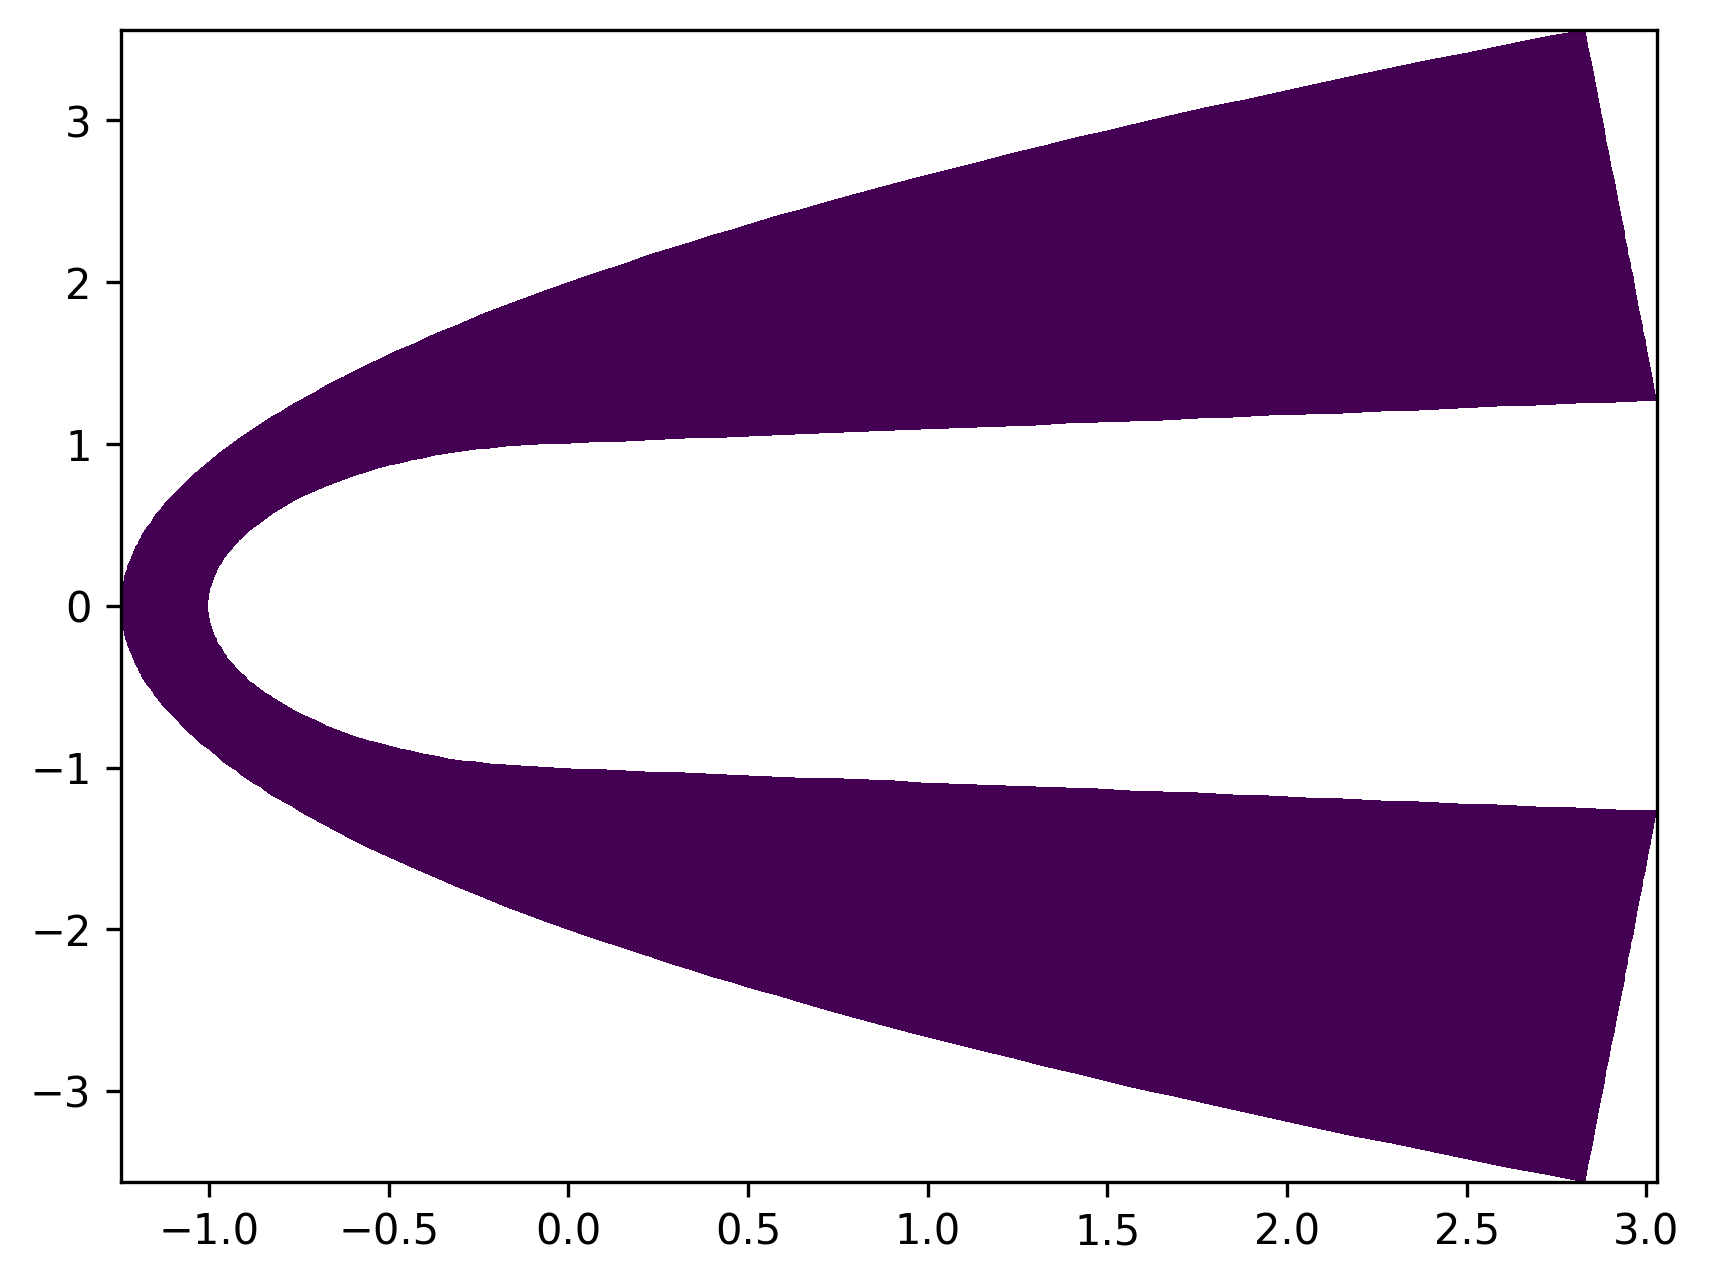

第1次迭代中...
误差为：9015.224490229792
第2次迭代中...
误差为：8620.76187437219
第3次迭代中...
误差为：8251.879356971489
第4次迭代中...
误差为：7906.423600153635
第5次迭代中...
误差为：7582.462452270505
第6次迭代中...
误差为：7278.25827773059
第7次迭代中...
误差为：6992.244961887549
第8次迭代中...
误差为：6723.008023571098
第9次迭代中...
误差为：6469.26736453203
第10次迭代中...
误差为：6229.862263793002
第11次迭代中...
误差为：6003.738289255743
第12次迭代中...
误差为：5789.935851743512
第13次迭代中...
误差为：5587.580170188377
第14次迭代中...
误差为：5395.872452674607
第15次迭代中...
误差为：5214.082127930731
第16次迭代中...
误差为：5041.539986748934
第17次迭代中...
误差为：4877.632113604969
第18次迭代中...
误差为：4721.794506182755
第19次迭代中...
误差为：4573.508295164177
第20次迭代中...
误差为：4432.295489004544
第21次迭代中...
误差为：4297.715178867454
第22次迭代中...
误差为：4169.360147758006
第23次迭代中...
误差为：4046.8538354318034
第24次迭代中...
误差为：3929.8476170841795
第25次迭代中...
误差为：3818.0183593173388
第26次迭代中...
误差为：3711.066221589377
第27次迭代中...
误差为：3608.7126753910998
第28次迭代中...
误差为：3510.6987168755822
第29次迭代中...
误差为：3416.783251666682
第30次迭代中...
误差为：3326.741633167505
第31次迭代中...
误差为：32

KeyboardInterrupt: 

In [43]:

if __name__ == '__main__':
    finite = FiniteV('/home/xfw/cfd/data/mesh2d.dat')
    finite.calc()
    # print(finite.x[0:2, 0:2])
    # print(finite.y[0:2, 0:2])